# Fitting Functions

## Least Squares Regression

Here we are going to learn how to fit functions in Python. Lets start with a simple example where we create some random data in the shape of a sine curve with some amplitude and phase.

In this example, lets pretend we are a bit too optimisitc about the data and we severly underestimate the errors on our meaurments.

As a note, this notebook is partly informed by this example (https://emcee.readthedocs.io/en/stable/tutorials/line/), so thank you  Dan Foreman-Mackey!

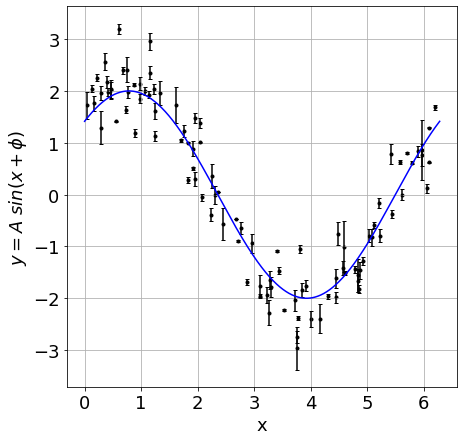

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

def sine(x,amp,phase):
    """
    x: input in radians
    amp: amplitude of sine curve
    phase: phase of the sine curve in radians
    """
    return amp*np.sin(x+phase)

np.random.seed(42)

#generate 100 random points between 0 and 2 pi
N_samp = 100
x = np.random.random(N_samp)*2*np.pi

#set amplitude and phase
amp = 2.
phase = np.pi / 4

# get true value and then add noise
y = sine(x, amp, phase)
#add normally distributed noise with some standard deviation
std = 0.5
y += np.random.randn(N_samp) * std
# give normally distributed errors on data that is underestimated
f = 0.3
yerr = np.random.randn(N_samp) * std * f

#plot the data
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.facecolor'] = 'white'
plt.figure(figsize=(7,7))
plt.scatter(x, y, c='k', marker='.')
plt.errorbar(x, y, yerr=yerr, fmt='none', ecolor='k', capsize=2)
xcont = np.linspace(0, 2*np.pi, 1000)
plt.plot(xcont, sine(xcont, amp, phase), c='b', label='True')
plt.grid()
plt.xlabel('x')
plt.ylabel(r'$y=A\ sin(x+\phi)$')
plt.show()

Now let us try to fit our data using least squares regression. This assumes that the errorbars are correct, Gaussian and independent, which is not correct for our example, but let us continue anyways. Here we will use the scipy.optimize function curve_fit as this has already implemented non-linear least squares regression for us.

Fitted Amplitude = 1.7210, Difference from True Value = 0.2790
Fitted Phase = 0.7449, Difference from True Value = 0.0405


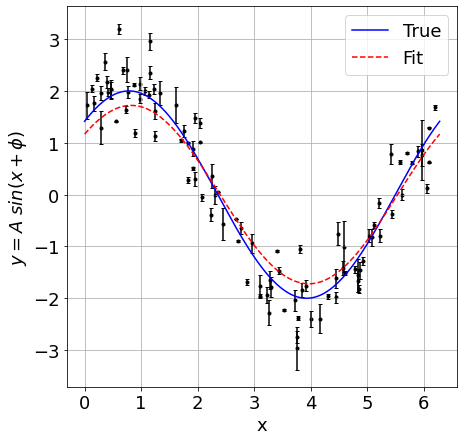

In [2]:
from scipy.optimize import curve_fit

params = curve_fit(sine, x, y,  sigma=yerr)[0]

print('Fitted Amplitude = %.4f, Difference from True Value = %.4f' % (params[0],
                                                                  abs(amp-params[0])))
print('Fitted Phase = %.4f, Difference from True Value = %.4f' % (params[1],
                                                              abs(phase-params[1])))

#plot the data
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.facecolor'] = 'white'
plt.figure(figsize=(7,7))
plt.scatter(x, y, c='k', marker='.')
plt.errorbar(x, y, yerr=yerr, fmt='none', ecolor='k', capsize=2)
xcont = np.linspace(0, 2*np.pi, 1000)
plt.plot(xcont, sine(xcont, amp, phase), c='b', label='True')
plt.plot(xcont,sine(xcont,*params),'--',c='r',label='Fit')
plt.legend()
plt.grid()
plt.xlabel('x')
plt.ylabel(r'$y=A\ sin(x+\phi)$')
plt.show()

As we can see, this is a fairly poor fit compared to the true solution.

## Maximum Likelihood

Another option is for us to maximize the likelihood function that actually describes these data:

$$
ln[p(y | x, \sigma, A, \phi)] = - \frac{1}{2} \sum_i \left[ \frac{(y_i - A\ sin(x_i+\phi))^2}{s_i^2} + ln(2 \pi s_i^2) \right]
$$
where
$$
s_i^2 = \sigma_i^2 - f^2
$$

This can be implemented and minimized below:

/Users/imedan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


Maximum likelihood estimates:
Fitted Amplitude = 2.0199, Difference from True Value = 0.0199
Fitted Phase = 0.7254, Difference from True Value = 0.0600
Fitted frac = 0.3021, Difference from True Value = 0.0021


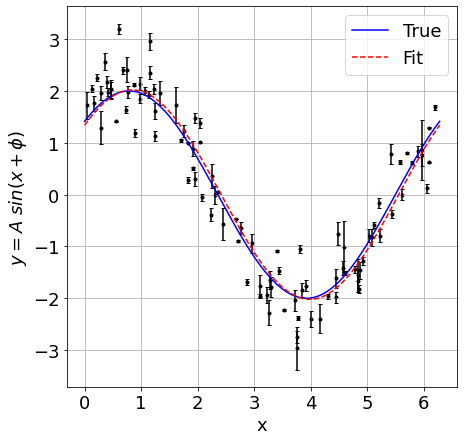

In [3]:
from scipy.optimize import minimize

def log_likelihood(theta, x, y, yerr):
    amp, phase, log_f = theta
    model = sine(x, amp, phase)
    sigma2 = yerr ** 2 - np.exp(log_f) ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(2 * np.pi * sigma2))

nll = lambda *args: -log_likelihood(*args)
initial = np.array([amp, phase, np.log(f)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("Fitted Amplitude = %.4f, Difference from True Value = %.4f" % (m_ml,
                                                                  abs(amp-m_ml)))
print('Fitted Phase = %.4f, Difference from True Value = %.4f' % (b_ml,
                                                              abs(phase-b_ml)))
print('Fitted frac = %.4f, Difference from True Value = %.4f' % (np.exp(log_f_ml),
                                                              abs(f-np.exp(log_f_ml))))

#plot the data
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.facecolor'] = 'white'
plt.figure(figsize=(7,7))
plt.scatter(x, y, c='k', marker='.')
plt.errorbar(x, y, yerr=yerr, fmt='none', ecolor='k', capsize=2)
xcont = np.linspace(0, 2*np.pi, 1000)
plt.plot(xcont, sine(xcont, amp, phase), c='b', label='True')
plt.plot(xcont,sine(xcont,m_ml,b_ml),'--',c='r',label='Fit')
plt.legend()
plt.grid()
plt.xlabel('x')
plt.ylabel(r'$y=A\ sin(x+\phi)$')
plt.show()

This fit is much better now! But how can we actually get some errors on this estimated fit?

## Bootstrapping Errors

To get the errors on our fit, we are actually able to use bootstrapping! This will involve re-fitting a random subset of our data (with repeating) the same size as the original sample for many iterations. This will allow us to probe the varriance in the dataset and thus probes the random varriation in the regression.

This kind of fit is implemented below:

  0%|          | 0/10000 [00:00<?, ?it/s]

/Users/imedan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


Bootstrap Amplitude = 1.9988 +/- 0.1009, Difference from True Value = 0.0012
Bootstrap Phase = 0.7842 +/- 0.1008, Difference from True Value = 0.0012
Bootstrap frac = 0.3000 +/- 0.0997, Difference from True Value = 0.0000


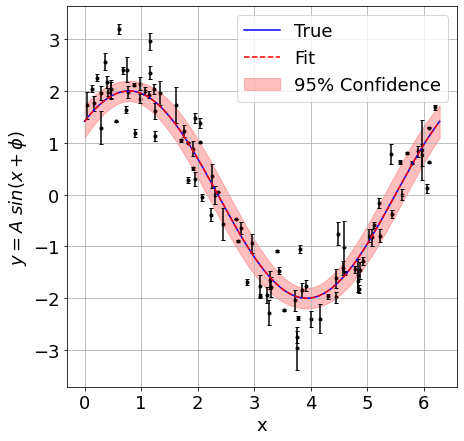

In [4]:
from tqdm.notebook import trange

def bootstrap_fit(x, y, yerr, N_params, N):
    """
    x: x data to fit
    y: ydata to fit
    yerr: noise added to the y data
    N_params: number of paramaters being fit in the function
    N: number of iterations in the bootstrap
    """
    params_all = np.zeros((N, N_params))
    for i in trange(N):
        #create random indexes to draw from the data
        idx=np.random.randint(0, len(x), len(x))
        # fit the randomlly selected data
        # with a new random initial point
        initial = np.array([amp, phase, np.log(f)]) + 0.1 * np.random.randn(3)
        soln = minimize(nll, initial, args=(x[idx], y[idx], yerr[idx]))
        #save the params
        params_all[i,:] = soln.x
    return params_all

params_all = bootstrap_fit(x, y, yerr, 3, 10000)
params = np.mean(params_all, axis=0)
#get the standard deviation in the paramaters
params_std = np.std(params_all, axis=0)

print('Bootstrap Amplitude = %.4f +/- %.4f, Difference from True Value = %.4f' % (params[0],
                                                                                  params_std[0],
                                                                                  abs(amp-params[0])))
print('Bootstrap Phase = %.4f +/- %.4f, Difference from True Value = %.4f' % (params[1],
                                                                              params_std[1],
                                                                              abs(phase-params[1])))
print('Bootstrap frac = %.4f +/- %.4f, Difference from True Value = %.4f' % (np.exp(params[2]),
                                                                             params_std[2],
                                                                             abs(f-np.exp(params[2]))))

#plot the fit
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.facecolor'] = 'white'
plt.figure(figsize=(7,7))
plt.scatter(x, y, c='k', marker='.')
plt.errorbar(x, y, yerr=yerr, fmt='none', ecolor='k', capsize=2)

xcont=np.linspace(0,2*np.pi,1000)
plt.plot(xcont,sine(xcont,amp,phase),c='b',label='True')
plt.plot(xcont,sine(xcont,*params[:-1]),'--',c='r',label='Fit')

#do error propogation to get 95% confidence interval
#wont go into detail about this, see other portions of the workshop
y_fit_err=np.sqrt((np.sin(xcont+params[1])*params_std[0])**2+(params[0]*np.cos(xcont+params[1])*params_std[1])**2)
plt.fill_between(xcont,sine(xcont,*params[:-1])-1.95*y_fit_err,sine(xcont,*params[:-1])+1.95*y_fit_err,color='r',alpha=0.25,
                label='95% Confidence')

plt.legend()
plt.grid()
plt.xlabel('x')
plt.ylabel(r'$y=A\ sin(x+\phi)$')
plt.show()

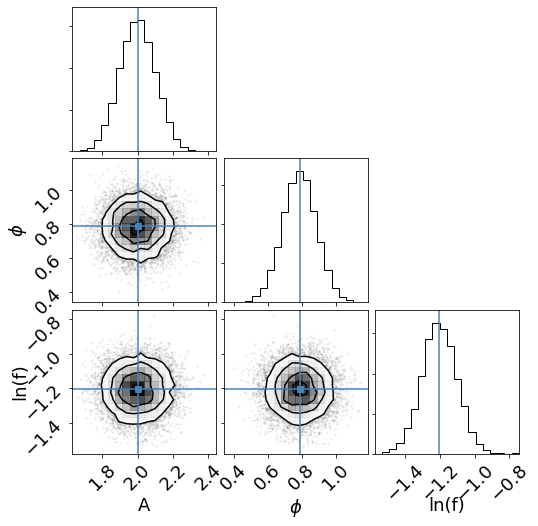

In [5]:
import corner

fig = corner.corner(
    params_all, labels=['A', r'$\phi$', 'ln(f)'], truths=[amp, phase, np.log(f)]
);

As we can see from the results, we have a very good fit to our data and the 95% confidence interval includes a good chunk of our dataset! So it seems like we have done a good job of fitting our data and estimating realistic errors on the model parameters.